# Plotting `clifford` 2D PGA objects with `matplotlib`
Ted Corcovilos
2021-03-09

In [1]:
from clifford import *

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [4]:
# the widgets seem to be broken for now, so switching to static plots
%matplotlib inline
#%matplotlib widget

In [5]:
import warnings

In [6]:
# define 2D PGA
layout, blades = Cl(2,0,1, firstIdx=0)
locals().update(blades)

In [7]:
# helper functions
point = lambda x, y, w=1.0 : (x*e1+y*e2+w*e0).dual()
line = lambda a, b, c: a*e1+b*e2+c*e0

In [8]:
def rand_line(num=1,length=1.0):
    '''
    generates 'num' random (normalized) lines with maximum moment of 'length'
    '''
    # a line looks like xe1 + ye2 + ce0 and is normalized if x**2 + y**2 = 1
    # So, we'll use a polar form for x and y
    angle = 2.0*np.pi* np.random.random(num) # random angle between 0 and 2pi radians
    x = np.cos(angle)
    y = np.sin(angle)
    c = np.random.random(num)*length
    if num == 1:
        line = MultiVector(layout,[0,c[0],x[0],y[0],0,0,0,0])
    else:
        line = [MultiVector(layout,[0,c[i],x[i],y[i],0,0,0,0]) for i in range(num)]
    return(line)
    

In [9]:
def rand_point(num=1,length=1.0):
    '''
    generates 'num' random (normalized) lines with maximum moment of 'length'.
    length=0 generates ideal points
    '''
    # a normalized point looks like -xe02 + ye01 + e12 
    # So, we'll use a polar form for x and y
    angle = 2.0*np.pi* np.random.random(num) # random angle between 0 and 2pi radians
    if length == 0:
        x = np.cos(angle)
        y = np.sin(angle)
        w = 0.0
    else:    
        c = np.random.random(num)*length
        x = np.cos(angle)*c
        y = np.sin(angle)*c
        w = 1.0
        
    if num == 1:
        line = MultiVector(layout,[0,0,0,0,y[0],-x[0],w,0])
    else:
        line = [MultiVector(layout,[0,0,0,0,y[i],-x[i],w,0]) for i in range(num)]
    return(line)
    

## The plotting function `add_to_axes`
This draws a PGA object to an existing `matplotlib` axes object. The function classifies the object by geometric type then draws an appropriate representation onto the figure axes.

In [10]:
def add_to_axes(x,label=None,color='black',axis=None,eps = 1e-6,**kwargs):
    # plot 2D PGA points and lines on a pyplot axis
    # label = point label for drawing
    # axis = axis object to write to, defaults to last used
    # eps = threshold for rounding to zero during type check
    
    # FIXME things are screwy if the object is outside the bounds of the figure
    
    x.clean(eps=eps)
    if axis==None:
        # get current axis
        axis = plt.gca()
    
    # get boundaries (for drawing lines)
    xmin, xmax = axis.get_xbound()
    ymin, ymax = axis.get_ybound()
    # bounding box as PGA lines:
    # corners
    corners = [point(xmin,ymin),point(xmax,ymin),point(xmax,ymax),point(xmin,ymax)]
    # edges 
    edges = [line(0,-1,ymin),line(-1,0,xmax),line(0,1,-ymax),line(1,0,-xmin)]
    
    # check object type:
    # real point, ideal point
    # line, idea line (how to draw?)
    grades = x.grades()
    if grades == set({1}): # it's a line!
        # check for ideal line
        if (x(e1) == 0) and (x(e2) == 0): # ideal line
            ellipse = Ellipse([0.5*(xmin+xmax),0.5*(ymin+ymax)],
                             width = xmax-xmin, height = ymax-ymin,
                             facecolor='none',edgecolor=color,ls='--')
            axis.add_artist(ellipse)
            axis.annotate(label,xycoords='figure fraction',
                         xy=(0.8,0.8), color=color, **kwargs)
        else: # real line
            # find which sides the line crosses
            # H/T enki
            crossing = [np.sign((corners[j]^x).value[7]*(corners[(j+1)%4]^x).value[7])==-1 for j in range(4)]
            edges_crossed = [edges[j] for j in range(4) if crossing[j]]
            if len(edges_crossed)==0:
                # the line is outside the box
                # FIXME edge cases: line intersects one of the corner points
                warnings.warn("Line outside window")
                return
            crosspoints = [x^j for j in edges_crossed]
            
            cross_x = [-j.value[5]/j.value[6] for j in crosspoints]
            cross_y = [j.value[4]/j.value[6] for j in crosspoints]
            axis.plot(cross_x,cross_y,color=color)
            
            labelx = 0.9*(-cross_x[0]+cross_x[1])+cross_x[0]
            labely = 0.9*(-cross_y[0]+cross_y[1])+cross_y[0]
            axis.annotate(
                label, xycoords='data',
                xy=(labelx,labely), textcoords='offset pixels',
                xytext=(5,5),
                color=color,
                **kwargs)
            

    elif grades == set({2}): # it's a point!
        # check if real point or ideal point
        if x(e12) == 0: # ideal point
            # ideal point will be drawn as an arrow at center of graph
            # TODO arrow at boundary?
            axis.annotate(
                label, xy=(0.5,0.5), xycoords='figure fraction',
                xytext=(-x.value[5]*0.1+0.5,x.value[4]*0.1+0.5), textcoords='figure fraction',
                arrowprops=dict(arrowstyle="<-",ec=color,fc=color),
                color=color,
                **kwargs)
        else: # real point
            axis.scatter(-x.value[5]/x.value[6],x.value[4]/x.value[6],color=color,**kwargs)
            axis.annotate(
                label, xycoords='data',
                xy=(-x.value[5]/x.value[6],x.value[4]/x.value[6]), textcoords='offset pixels',
                xytext=(5,5),
                color=color,
                **kwargs)
           
    else:
        # uh oh.  I don't know how to handle this
        # throw a warning and exit
        warnings.warn("Object is not a point or line.  Ignoring.")

## Generate some example objects

In [11]:
# generate 3 points
A, B, C = rand_point(3,1.0)
[A,B,C]

[-(0.19078^e01) + (0.21925^e02) + (1.0^e12),
 (0.06767^e01) + (0.5542^e02) + (1.0^e12),
 (0.40487^e01) - (0.49553^e02) + (1.0^e12)]

In [12]:
# calculate (unnormalized) lines between the points
a = B & C # also `B & C` works
b = C & A
c = A & B
[a,b,c]

/home/corcoted/gitrepos/GA-scratch/env/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


[-(0.25791^e0) - (0.33721^e1) + (1.04973^e2),
 -(0.00577^e0) + (0.59565^e1) - (0.71477^e2),
 -(0.12057^e0) - (0.25845^e1) - (0.33495^e2)]

In [13]:
idealpoint = rand_point(1,0)
idealline = 1*e0

## Make a plot

/home/corcoted/gitrepos/GA-scratch/env/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/corcoted/gitrepos/GA-scratch/env/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/tmp/ipykernel_5270/1411504146.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


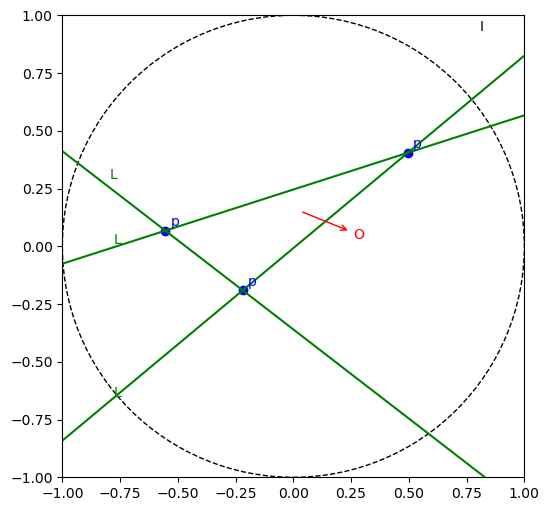

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.axis([-1,1,-1,1])
# to avoid weird results, set the axis limits before plotting
#ax.set_ylim(-1,1)
#ax.set_xlim(-1,1)
for XX in [A,B,C]:
    add_to_axes(XX,label="p",color='blue')
ax.set_aspect(1) # rescale axes
add_to_axes(idealpoint,label="O",color='red')
for XX in [a,b,c]:
    add_to_axes(XX,label="L",color='green')
add_to_axes(idealline,label="I",color='black')

fig.show()